1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df_default=pd.get_dummies(df['default'])
df_default=df_default.drop(['No'],1)
df_default.rename(columns={'Yes':'default'}, inplace=True)

df_student=pd.get_dummies(df['student'])
df_student=df_student.drop(['No'],1)
df_student.rename(columns={'Yes':'student'}, inplace=True)

df_final = pd.concat([df_default,df_student,df[['balance','income']]],axis=1)
df_final.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

/Users/liweiyi/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/liweiyi/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


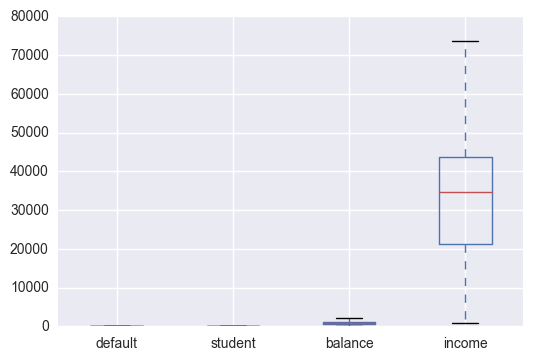

In [3]:
from matplotlib import pylab as plt
import seaborn
%matplotlib inline

df_final.boxplot()

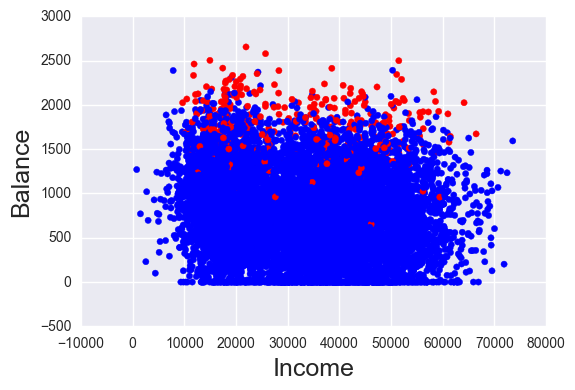

In [4]:
color = []
for i in range(len(df_final['default'])):
    if df_final['default'][i] == 1:
        color.append('r')
    elif df_final['default'][i] == 0:
        color.append('b')

plt.scatter(df_final['income'],df_final['balance'],color=color)
plt.xlabel('Income', fontsize=18)
plt.ylabel('Balance', fontsize=18)

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

/Users/liweiyi/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coef. Decision Boundary:0.000019 0.005500


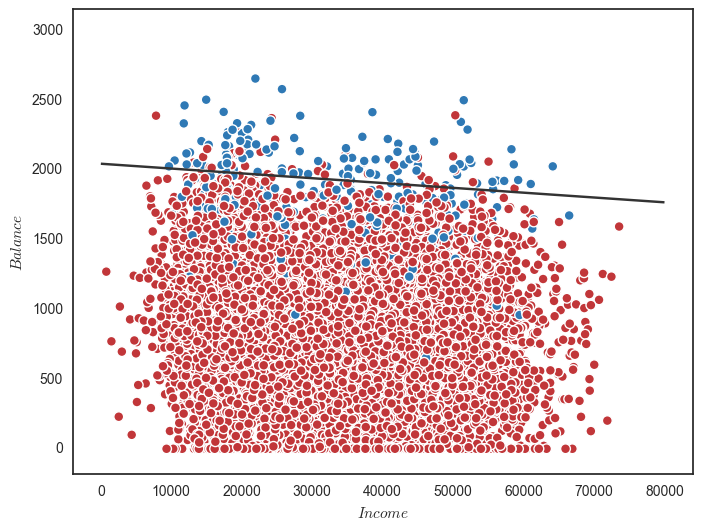

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import seaborn as sns
sns.set(style="white")

data = pd.concat([df_final[['income','balance','default']]],axis=1)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]
X = np.array(X.values)
y = np.array(y.values)
clf = LogisticRegression(penalty='l1').fit(X, y)
print ('Coef. Decision Boundary:%f %f') % (clf.coef_[0][0],clf.coef_[0][1])
xx, yy = np.mgrid[0:80000:10, 0:3000:1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set(xlabel="$Income$", ylabel="$Balance$")
plt.show()

Area under the ROC curve : 0.960663


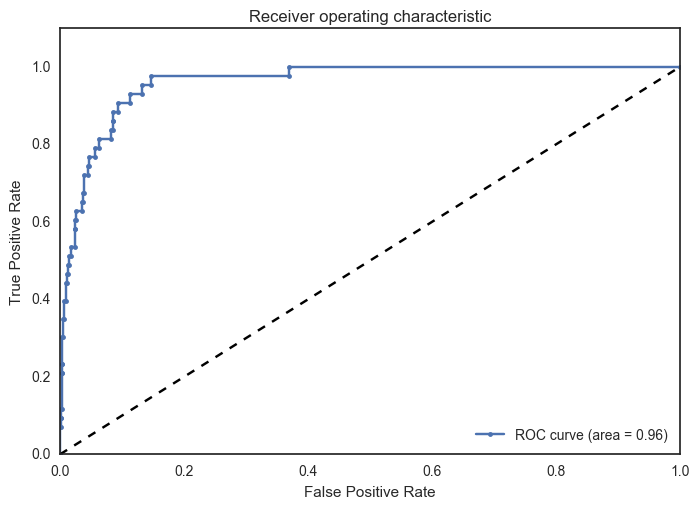

In [6]:
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [7]:
data = pd.concat([df_final[['student','income','balance','default']]],axis=1)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]
X = np.array(X.values)
y = np.array(y.values)
clf = LogisticRegression(penalty='l1').fit(X, y)
print ('Coef. Decision Boundary:%f %f %f') % (clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2])

# The "student" variable seems highly correlated with the "income" variable. So we should consider the covariance.

Coef. Decision Boundary:-0.784617 -0.000005 0.005424


6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [8]:
# Compare the residual sum of squares for 10 cross validation with different random folds

from sklearn.cross_validation import KFold
from numpy import linalg as LA

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_ = clf.predict(X_test)
        for i in range(len(test_index)):
            y_pred[test_index[i]] = y_[i]
    return y_pred

def RSS_output(Num):
    RSS_=[]
    i = 0
    while i < Num:
        y_pred = run_cv(X=X,y=y,clf_class=LogisticRegression,penalty='l1')
        RSS = LA.norm(y-y_pred)**2
        RSS_.append(RSS)
        i = i+1
    return RSS_
print 'RSS of each cross validation:',RSS_output(10)

# The RSS is quite stable. 


/Users/liweiyi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


RSS of each cross validation: [2406155.0, 2471182.0, 2471182.0, 2341134.0, 2406163.0000000005, 2406157.0, 2406159.9999999995, 2406157.0, 2341135.0000000005, 2471182.0]


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

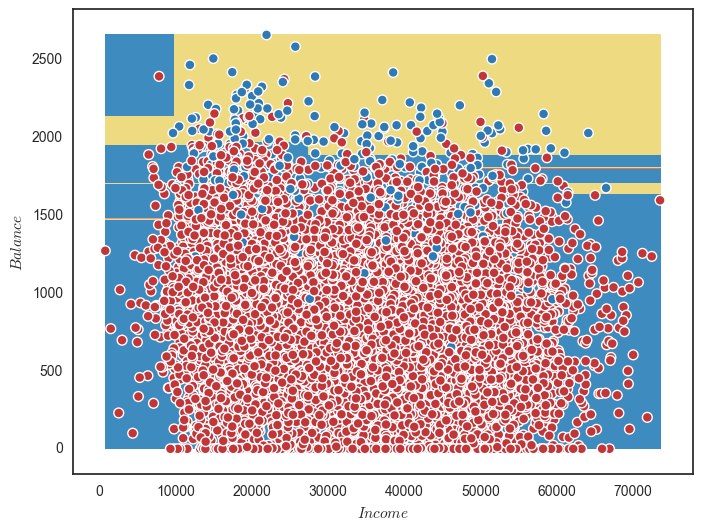

In [9]:
from sklearn.tree import DecisionTreeClassifier

data = pd.concat([df_final[['income','balance','default']]],axis=1)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]
X = np.array(X.values)
y = np.array(y.values)
clf = DecisionTreeClassifier(max_depth=5).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max),np.arange(y_min, y_max))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set(xlabel="$Income$", ylabel="$Balance$")
plt.show()

8) Find the optimal decision tree depth and compute the AUC ROC. 

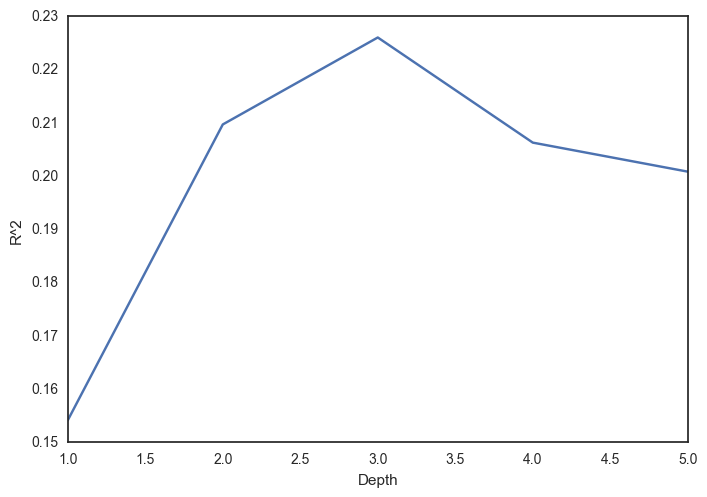

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]


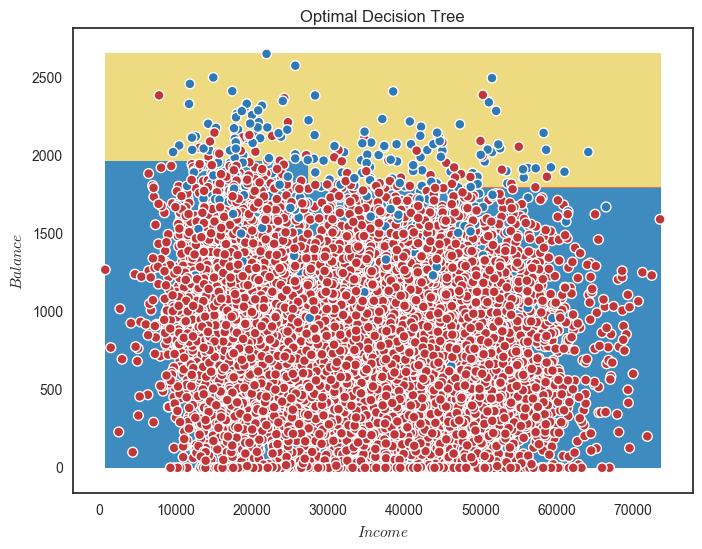

In [12]:
clf = DecisionTreeClassifier(max_depth=n_opt).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max),np.arange(y_min, y_max))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set(xlabel="$Income$", ylabel="$Balance$",title="Optimal Decision Tree")
plt.show()

Area under the ROC curve : 0.951562


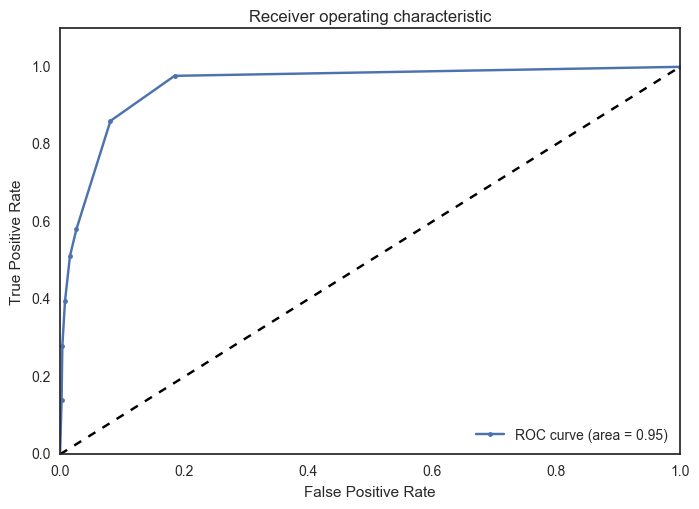

In [13]:
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=n_opt)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
